In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from IPython.display import HTML
from matplotlib import animation, rc
from scipy.integrate import quad

In [2]:
#Are you team Tau or team Pi?
tau = 2*np.pi

%matplotlib inline

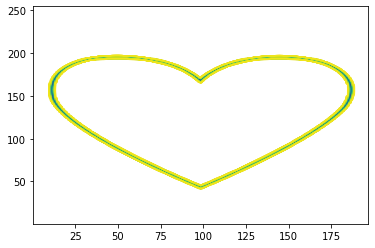

In [3]:
#import image
im = PIL.Image.open("heart.png").convert("L")    # gray_scall e convert
contour_plot = plt.contour(im,levels =50,origin='image')

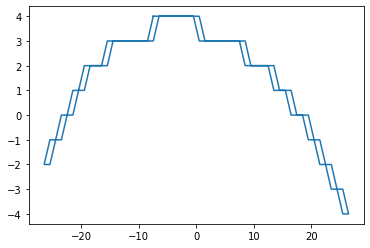

In [4]:
#Find path
contour_path = contour_plot.collections[0].get_paths()[0]
X, Y = contour_path.vertices[:,0], contour_path.vertices[:,1]

#Center X and Y
X = X - min(X)
Y = Y - min(Y)
X = X - max(X)/2
Y = Y - max(Y)/2

#Visualize
plt.plot(X,Y)
#For the period of time 0-2*pi
time = np.linspace(0,tau,len(X))

In [5]:
def f(t, time_table, x_table, y_table):
    #Convert the X and Y coords to complex number over time
    X = np.interp(t, time_table, x_table) 
    Y = 1j*np.interp(t, time_table, y_table)
    return X + Y


def coef_list(time_table, x_table, y_table, order=5):
    #Find the real and imaginary parts of the coefficients to the summation
    coef_list = []
    for n in range(-order, order+1):
        #integrate across f .
        real_coef = quad(lambda t: np.real(f(t, time_table, x_table, y_table) * np.exp(-n*1j*t)), 0, tau, limit=100, full_output=1)[0]/tau
        imag_coef = quad(lambda t: np.imag(f(t, time_table, x_table, y_table) * np.exp(-n*1j*t)), 0, tau, limit=100, full_output=1)[0]/tau
        coef_list.append([real_coef, imag_coef])
    return np.array(coef_list)

def DFT(t, coef_list, order=5):
    #Compute the discrete fourier series with a given order
    kernel = np.array([np.exp(-n*1j*t) for n in range(-order, order+1)])
    series = np.sum( (coef_list[:,0]+1j*coef_list[:,1]) * kernel[:])
    return np.real(series), np.imag(series)

In [6]:
def visualize(x_DFT, y_DFT, coef, order, space, fig_lim):

    fig, ax = plt.subplots()
    lim = max(fig_lim)
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.set_aspect('equal')

    # Initialize
    line = plt.plot([], [], 'k.-', linewidth=2)[0]
    radius = [plt.plot([], [], 'b-', linewidth=0.5, marker='o', markersize=1)[0] for _ in range(2 * order + 1)]
    circles = [plt.plot([], [], 'b-', linewidth=0.5)[0] for _ in range(2 * order + 1)]

    def update_c(c, t):
        new_c = []
        for i, j in enumerate(range(-order,order + 1)):
            dtheta = -j * t
            ct, st = np.cos(dtheta), np.sin(dtheta)
            v = [ct * c[i][0] - st * c[i][1], st * c[i][0] + ct * c[i][1]]
            new_c.append(v)
        return np.array(new_c)

    def sort_velocity(order):
        #reorder the frequencies
        idx = []
        for i in range(1,order+1):
            idx.extend([order+i, order-i]) 
        return idx    

    def animate(i):
        # animate lines
        line.set_data(x_DFT[:i], y_DFT[:i])
        # animate circles
        r = [np.linalg.norm(coef[j]) for j in range(len(coef))]
        pos = coef[order]
        c = update_c(coef, i / len(space) * tau)
        idx = sort_velocity(order)
        for j, rad, circle in zip(idx,radius,circles):
            new_pos = pos + c[j]
            rad.set_data([pos[0], new_pos[0]], [pos[1], new_pos[1]])
            theta = np.linspace(0, tau, 50)
            x, y = r[j] * np.cos(theta) + pos[0], r[j] * np.sin(theta) + pos[1]
            circle.set_data(x, y)
            pos = new_pos

    # Animation
    ani = animation.FuncAnimation(fig, animate, frames=len(space), interval=10)
    return ani

In [7]:
order = 5
coef = coef_list(time, X, Y, order)
space = np.linspace(0,tau,300)
x_DFT = [DFT(t, coef, order)[0] for t in space]
y_DFT = [DFT(t, coef, order)[1] for t in space]

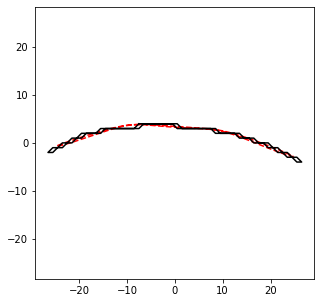

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_DFT, y_DFT, 'r--')
ax.plot(X, Y, 'k-')
ax.set_aspect('equal', 'datalim')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

In [9]:
order = 100
coef = coef_list(time, X, Y, order)
space = np.linspace(0,tau,300)
x_DFT = [DFT(t, coef, order)[0] for t in space]
y_DFT = [DFT(t, coef, order)[1] for t in space]

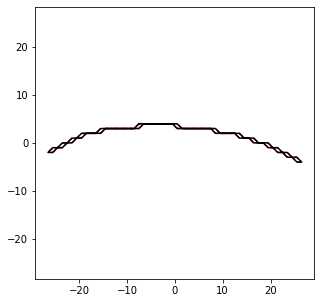

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_DFT, y_DFT, 'r--')
ax.plot(X, Y, 'k-')
ax.set_aspect('equal', 'datalim')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

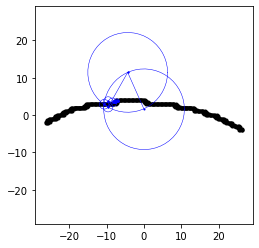

In [11]:
anim = visualize(x_DFT, y_DFT, coef, order,space, [xmin, xmax, ymin, ymax])

#Change based on what writer you have
#HTML(anim.to_html5_video())
#anim.save('pi.gif',writer='ffmpeg')
anim.save('love.gif',writer='pillow')